manipulate circuit


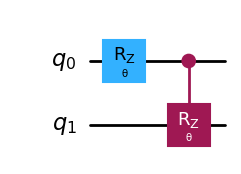

In [2]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta,0)
qc.crz(theta,0,1)

qc.draw("mpl")


code to produce the bloch sphere plots

AttributeError: 'QuantumCircuit' object has no attribute 'bind_parameters'

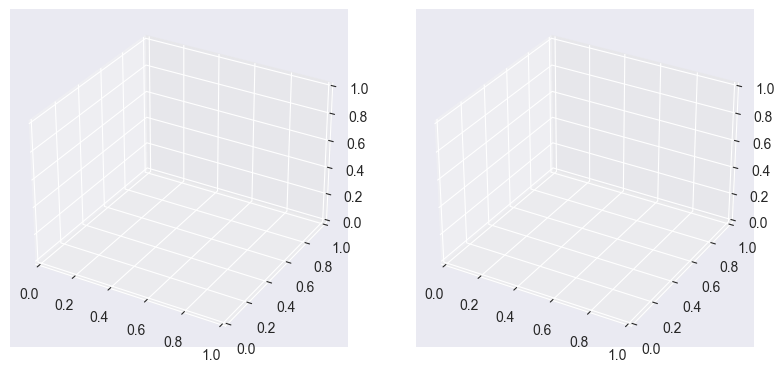

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)

# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))


b1.show()
b2.show()

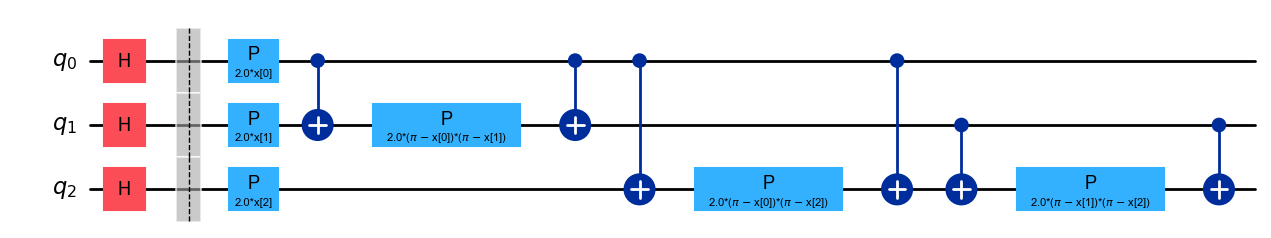

In [8]:
from qiskit.circuit.library import ZZFeatureMap
qc_zz = ZZFeatureMap(3, reps=1, insert_barriers=True)
qc_zz.decompose().draw()

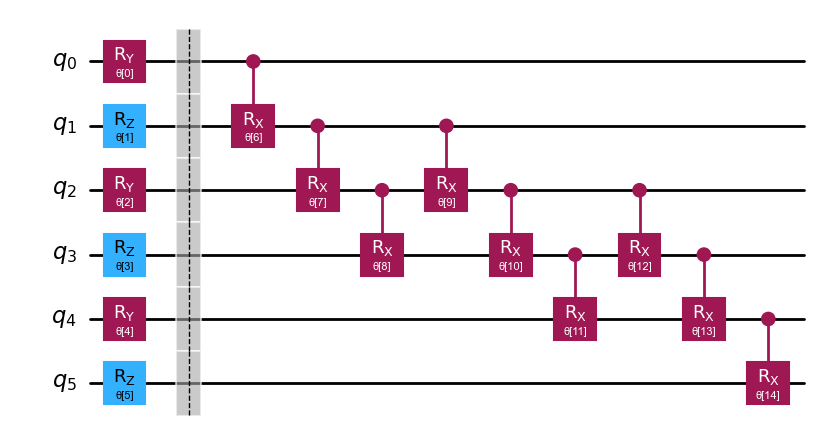

In [12]:
from qiskit.circuit.library import NLocal
from qiskit.circuit import ParameterVector
# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4)
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

qc_nlocal = NLocal(num_qubits=6, rotation_blocks=rot,
                   entanglement_blocks=ent, entanglement='linear',
                   skip_final_rotation_layer=True, insert_barriers=True)

qc_nlocal.decompose().draw()

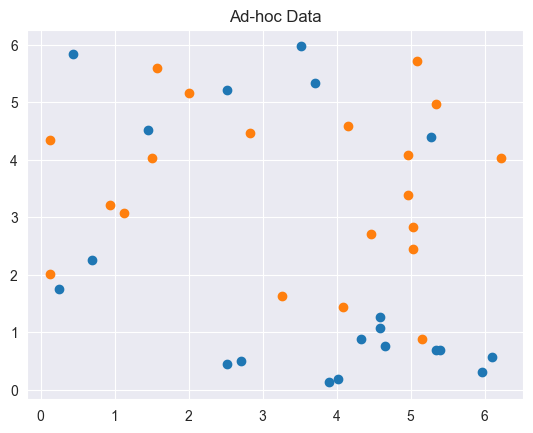

In [31]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=2,
    gap=0.3,
    plot_data=True,
    one_hot=False,
    include_sample_total=True,
)

In [32]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

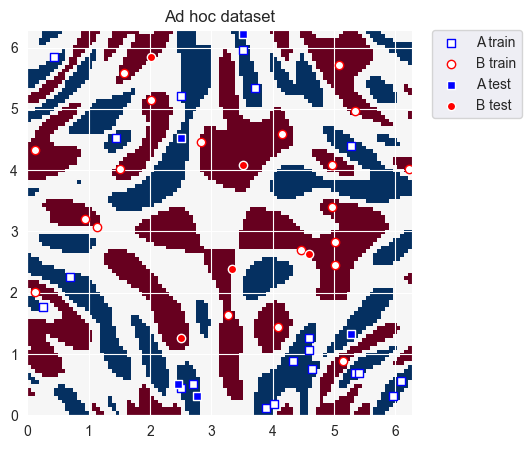

In [33]:
plot_dataset(train_features,train_labels,test_features,test_labels,adhoc_total)

In [35]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [37]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_features, train_labels)
adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)
print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


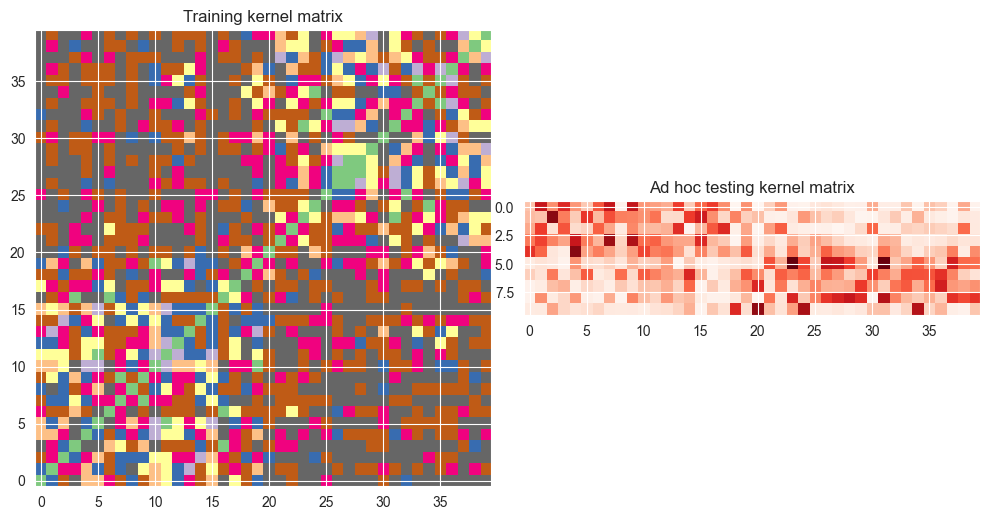

In [44]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(np.asmatrix(adhoc_matrix_train),interpolation="nearest",origin="lower",cmap="Accent_r")
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.tight_layout()
plt.show()

In [45]:
adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(adhoc_score_precomputed_kernel)



1.0


In [46]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


clustering 

In [58]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

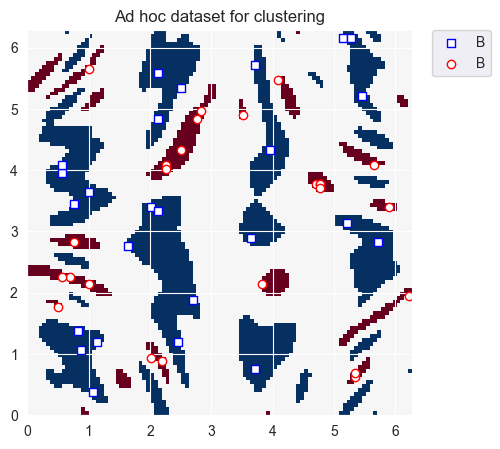

In [59]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

# A label plot
plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "B")

# B label plot
plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for clustering")

plt.show()

In [60]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension,reps=2,entanglement="linear")
adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)


Text(0.5, 1.0, 'Ad hoc dataset')

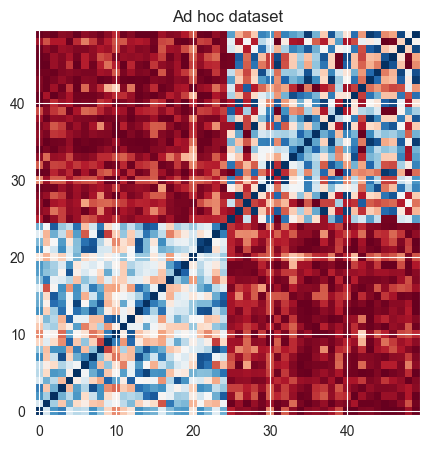

In [61]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(adhoc_matrix),interpolation="nearest",origin="lower",cmap="RdBu")
plt.title("Ad hoc dataset")


In [63]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

adhoc_spectral = SpectralClustering(2, affinity="precomputed")
cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)
cluster_socre = normalized_mutual_info_score(cluster_labels, train_labels)
print(cluster_socre)
                                    

1.0


kernel principal component analysis

In [64]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=10,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

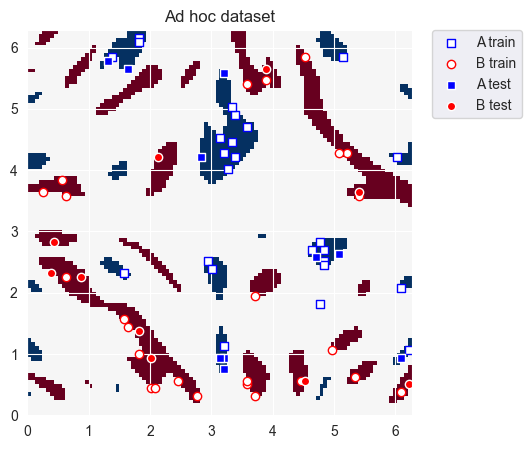

In [65]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

In [66]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
qpca_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [67]:
matrix_train = qpca_kernel.evaluate(x_vec=train_features)
matrix_test = qpca_kernel.evaluate(x_vec=test_features, y_vec=train_features)

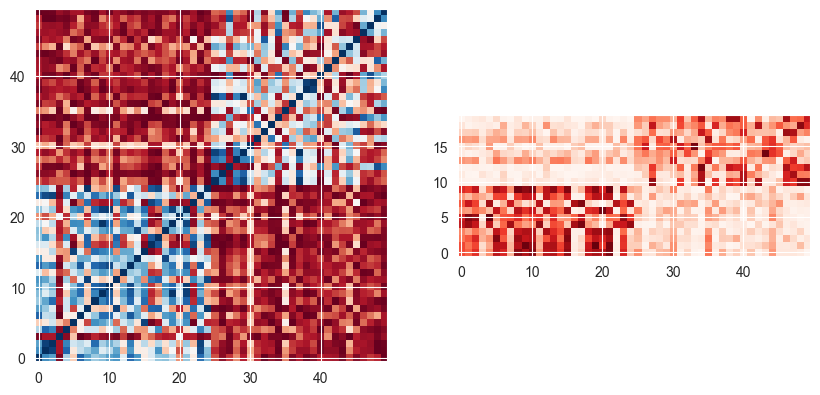

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),interpolation="nearest",origin="lower",cmap="RdBu")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="lower", cmap="Reds")


In [76]:
from sklearn.decomposition import KernelPCA

kernel_pca_rbf = KernelPCA(n_components=2, kernel = "rbf")
kernel_pca_rbf.fit(train_features)
train_features_rbf = kernel_pca_rbf.transform(train_features)
test_features_rbf = kernel_pca_rbf.transform(test_features)

kernel_pca_q = KernelPCA(n_components=2, kernel="precomputed")
train_features_q = kernel_pca_q.fit_transform(matrix_train)
test_features_q = kernel_pca_q.transform(matrix_test)

In [78]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_q, train_labels)

logistic_score = logistic_regression.score(test_features_q, test_labels)
print(f"Logistic regression score: {logistic_score}")

Logistic regression score: 1.0


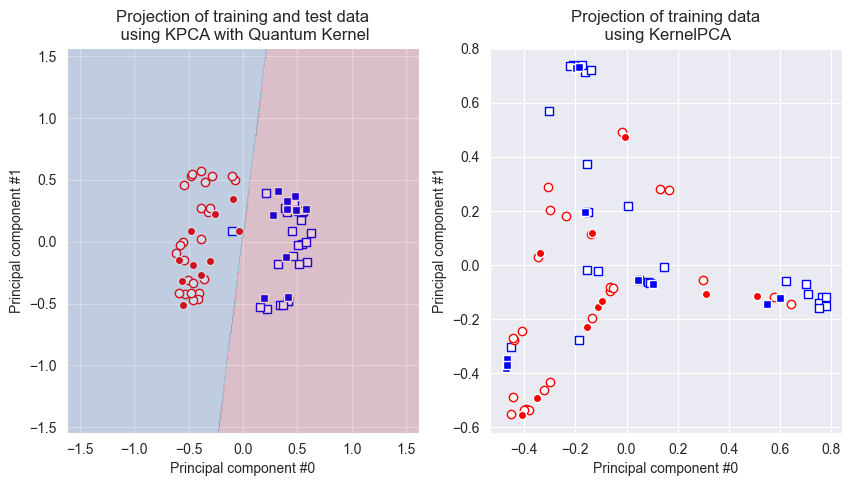

In [79]:
fig, (q_ax, rbf_ax) = plt.subplots(1, 2, figsize=(10, 5))


plot_features(q_ax, train_features_q, train_labels, 0, "s", "w", "b", "A train")
plot_features(q_ax, train_features_q, train_labels, 1, "o", "w", "r", "B train")

plot_features(q_ax, test_features_q, test_labels, 0, "s", "b", "w", "A test")
plot_features(q_ax, test_features_q, test_labels, 1, "o", "r", "w", "A test")

q_ax.set_ylabel("Principal component #1")
q_ax.set_xlabel("Principal component #0")
q_ax.set_title("Projection of training and test data\n using KPCA with Quantum Kernel")

# Plotting the linear separation
h = 0.01  # step size in the mesh

# create a mesh to plot in
x_min, x_max = train_features_q[:, 0].min() - 1, train_features_q[:, 0].max() + 1
y_min, y_max = train_features_q[:, 1].min() - 1, train_features_q[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

predictions = logistic_regression.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
predictions = predictions.reshape(xx.shape)
q_ax.contourf(xx, yy, predictions, cmap=plt.cm.RdBu, alpha=0.2)

plot_features(rbf_ax, train_features_rbf, train_labels, 0, "s", "w", "b", "A train")
plot_features(rbf_ax, train_features_rbf, train_labels, 1, "o", "w", "r", "B train")
plot_features(rbf_ax, test_features_rbf, test_labels, 0, "s", "b", "w", "A test")
plot_features(rbf_ax, test_features_rbf, test_labels, 1, "o", "r", "w", "A test")

rbf_ax.set_ylabel("Principal component #1")
rbf_ax.set_xlabel("Principal component #0")
rbf_ax.set_title("Projection of training data\n using KernelPCA")
plt.show()

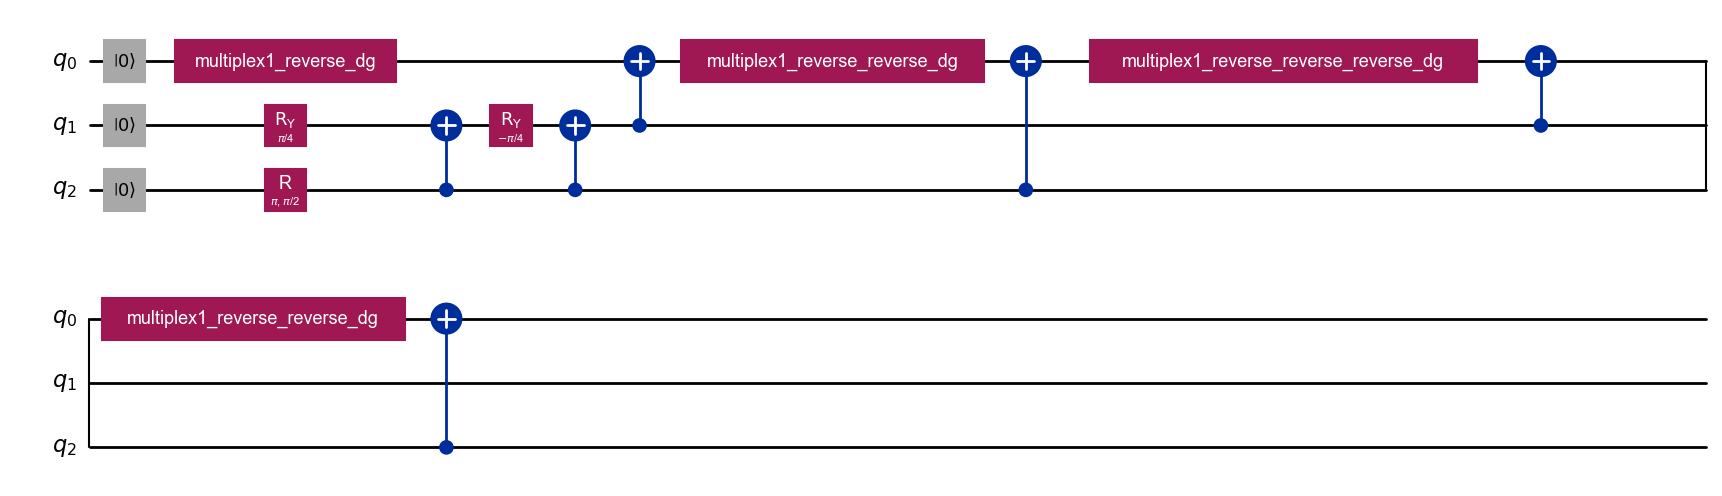

In [85]:
from qiskit import qasm, QuantumCircuit
import math

desired_state = [
    0,0,0,0,0,1 / math.sqrt(2),0,1 / math.sqrt(2)
]

qc = QuantumCircuit(3)

qc.initialize(desired_state)
qc.decompose().decompose().decompose().decompose().decompose().draw()

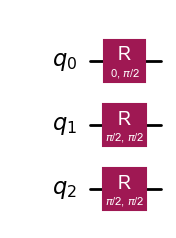

In [88]:
qc = QuantumCircuit(3)
qc.ry(0,0)
qc.ry(2*math.pi/4,1)
qc.ry(2*math.pi/4,2)
qc.decompose().draw()

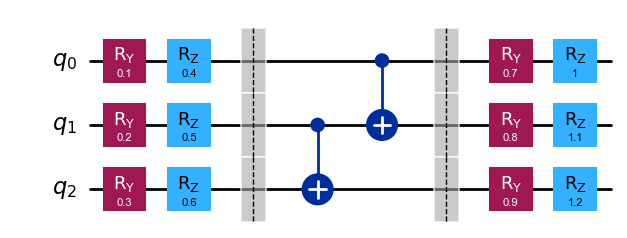

In [101]:
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit import Parameter
circuit = EfficientSU2(num_qubits=3,reps=1,insert_barriers=True)
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
param_bindings = {param: val for param, val in zip(circuit.parameters,x)}
circuit = circuit.assign_parameters(x)

circuit.decompose().draw()


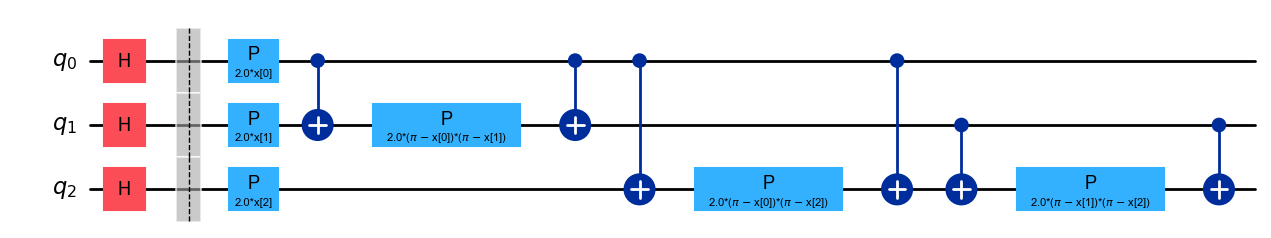

In [109]:
from qiskit.circuit.library import ZZFeatureMap
circuit = ZZFeatureMap(3, reps=1, insert_barriers=True)
circuit.decompose().draw()



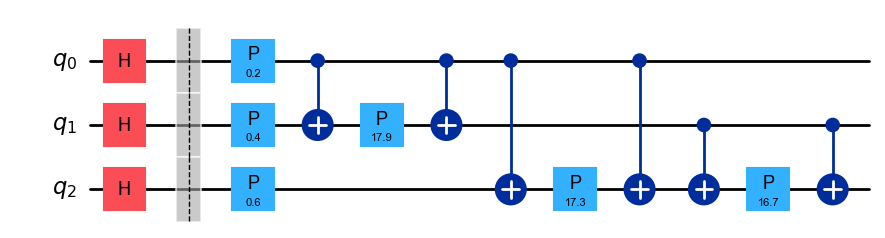

In [117]:
x = [0.1,0.2,0.3]
param_bindings = {param:value for param,value in zip(circuit.parameters,x)}
circuit = circuit.assign_parameters(param_bindings)
circuit.decompose().draw()